In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import umap
from scipy.stats import norm

from keras.layers import *
from keras.models import Model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data = np.load('data/full%2Fnumpy_bitmap%2Fcat.npy')

data = data.reshape(-1, 28, 28, 1) / 255.0
X = data[:10000]

# Model with densely encoded layer of arbitrary size

In [3]:
encoding_size = 32

input_image = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(input_image)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)

x = Flatten()(x)                                        # Squashing
x = Dense(256, activation='relu')(x)                    # Squashing
x = Dropout(0.2)(x)                                     # Squashing
encoded = Dense(encoding_size, activation='relu')(x)    # Dense, encoded layer
x = Dense(64*7*7, activation='relu')(encoded)           # Growing
x = Dropout(0.2)(x)                                     # Growing
x = Reshape((-1, 7, 7, 64)[1:])(x)                      # Growing

x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', data_format='channels_last')(x)

autoencoder = Model(input_image, decoded)

In [4]:
autoencoder.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['mse'])

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
__________

In [5]:
autoencoder.fit(X, X, 
                batch_size=32,
                validation_split=0.2,
                epochs=10)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 56s - loss: 0.3872 - mean_squared_error: 0.0913 - val_loss: 0.3383 - val_mean_squared_error: 0.0759
Epoch 2/10
8000/8000 [==============================] - 57s - loss: 0.3245 - mean_squared_error: 0.0711 - val_loss: 0.3038 - val_mean_squared_error: 0.0638
Epoch 3/10
8000/8000 [==============================] - 55s - loss: 0.3065 - mean_squared_error: 0.0648 - val_loss: 0.2903 - val_mean_squared_error: 0.0588
Epoch 4/10
8000/8000 [==============================] - 62s - loss: 0.2985 - mean_squared_error: 0.0618 - val_loss: 0.2814 - val_mean_squared_error: 0.0555
Epoch 5/10
8000/8000 [==============================] - 62s - loss: 0.2917 - mean_squared_error: 0.0592 - val_loss: 0.2758 - val_mean_squared_error: 0.0537
Epoch 6/10
8000/8000 [==============================] - 63s - loss: 0.2876 - mean_squared_error: 0.0578 - val_loss: 0.2710 - val_mean_squared_error: 0.0517
Epoch 7/10
8000/

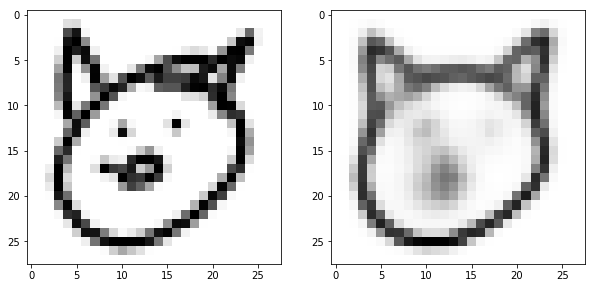

In [6]:
plt.rcParams['figure.figsize'] = (10, 5)

n = np.random.randint(len(data))

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data[n].reshape(28, 28),
                cmap='Greys');

axarr[1].imshow(autoencoder.predict(data[n].reshape(1, 28, 28, 1)).reshape(28, 28),
                cmap='Greys');

## Define encoder as well, using the weights from the full autoencoder, to encode all dogs into small latent space. then umap those latent vectors.

In [8]:
input_image = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',
           weights=autoencoder.layers[1].get_weights())(input_image)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',
           weights=autoencoder.layers[4].get_weights())(x)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',
           weights=autoencoder.layers[7].get_weights())(x)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Flatten()(x)
x = Dense(256, activation='relu',
          weights=autoencoder.layers[10].get_weights())(x)
x = Dropout(0.2)(x)
encoded = Dense(encoding_size, activation='relu',
          weights=autoencoder.layers[12].get_weights())(x)

encoder = Model(input_image, encoded)

[[ 1.4121834   1.41122854  1.96398556  0.7877444   1.30852878  3.42236114
   1.96261108  3.26254773  0.99273777  1.37021458  2.31461668  2.06044579
   2.19968963  2.6470089   4.52372694  7.72046232  1.87334871  2.76692963
   2.6736455   2.613343    2.20127177  5.18499994  3.25201607  0.49436599
   3.45095181  3.6941452   0.69184077  4.92837477  0.          5.04550219
   3.36235785  3.0694828 ]]


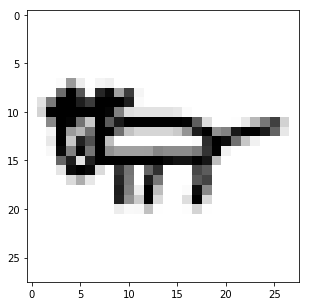

In [11]:
random_image = data[np.random.randint(len(data))].reshape(-1, 28, 28, 1)

print(encoder.predict(random_image))
plt.imshow(random_image.reshape(28, 28), cmap='Greys');

In [12]:
encoded_cats = encoder.predict(data[:20000].reshape(-1, 28, 28, 1))

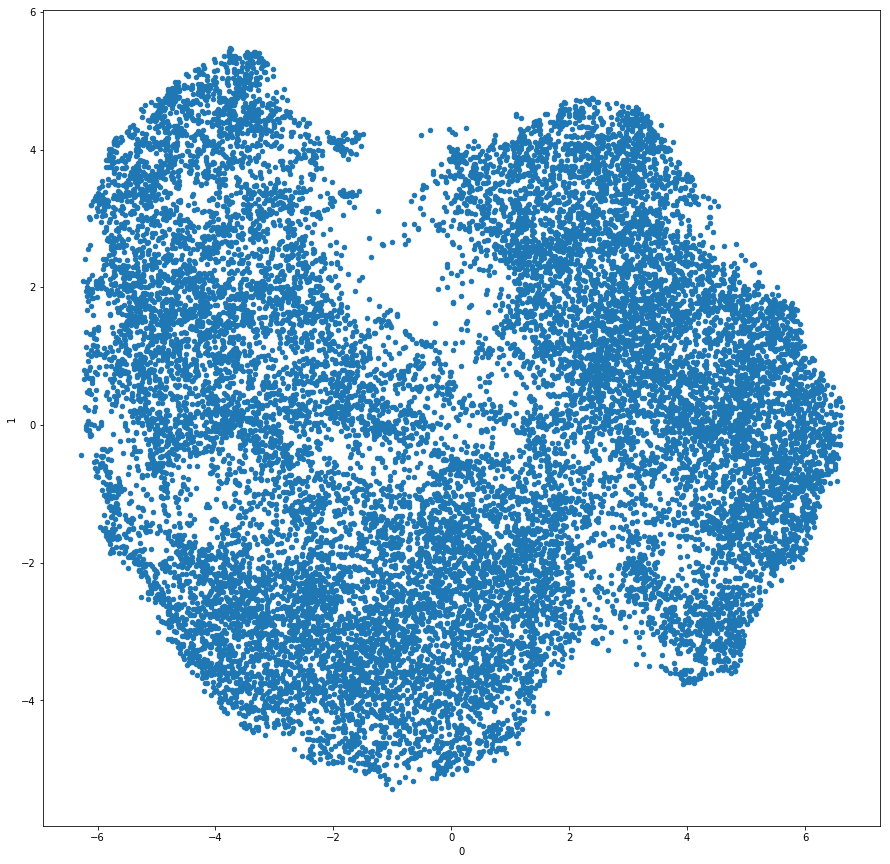

In [13]:
plt.rcParams['figure.figsize'] = (15, 15)

embedding = umap.UMAP().fit_transform(encoded_cats)
pd.DataFrame(embedding).plot.scatter(x=0, y=1);

## then encode arbitrary dogs?

this encoding is entirely machine-learned. no heuristics. can be of arbitrary size and the 'meaning' of each of the features in the encoded form is unknown. they can be inspected though.

## Create decoder network with the same weights as original autoencoder

In [14]:
latent_vector = Input(shape=(32,))
y = Dense(64*7*7, activation='relu', 
          weights=autoencoder.layers[13].get_weights())(latent_vector)
y = Reshape((-1, 7, 7, 64)[1:])(y)
y = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last', 
           weights=autoencoder.layers[16].get_weights())(y)
y = UpSampling2D((2, 2), data_format='channels_last')(y)
y = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last', 
          weights=autoencoder.layers[18].get_weights())(y)
y = UpSampling2D((2, 2), data_format='channels_last')(y)
y = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last', 
           weights=autoencoder.layers[20].get_weights())(y)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', data_format='channels_last', 
                 weights=autoencoder.layers[21].get_weights())(y)

decoder = Model(latent_vector, decoded)

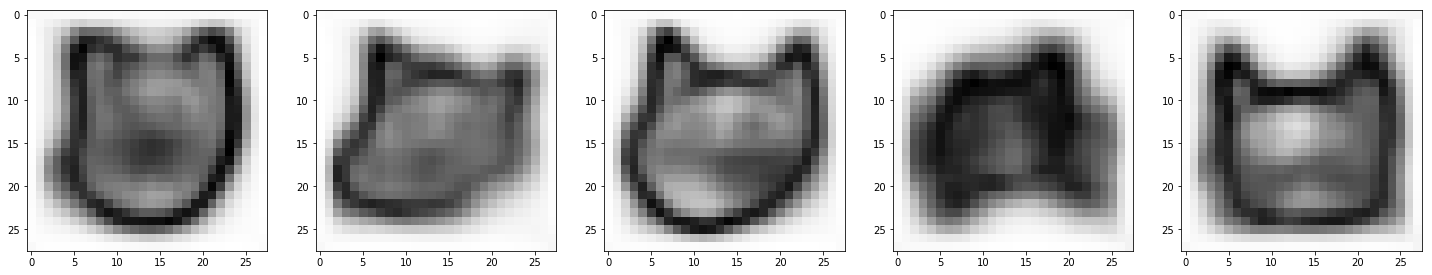

In [25]:
plt.rcParams['figure.figsize'] = (25, 5)
f, axarr = plt.subplots(1, 5)
for i in range(5):
    random_input = np.random.rand(32).reshape(-1, 32)
    axarr[i].imshow(decoder.predict(random_input).reshape(28, 28), cmap='Greys');

# Keras functional model with simple 2D sampling layer

In [26]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2), mean=0, stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [27]:
input_image = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(input_image)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)

# --- approach bottleneck ---
x = Flatten()(x)                                                    # Squashing
z_mean = Dense(2)(x)                                                # Squashing
z_log_var = Dense(2)(x)                                             # Squashing
encoded = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])  # Dense, encoded layer
x = Dense(64*7*7, activation='relu')(encoded)                       # Growing
x = Reshape((-1, 7, 7, 64)[1:])(x)                                  # Growing
# --- end bottleneck ---

x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', data_format='channels_last')(x)

autoencoder_2 = Model(input_image, decoded)

In [28]:
autoencoder_2.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['mse'])

autoencoder_2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_18 (Conv2D)               (None, 28, 28, 32)    320         input_5[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D)  (None, 14, 14, 32)    0           conv2d_18[0][0]                  
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 14, 14, 32)    0           max_pooling2d_10[0][0]           
___________________________________________________________________________________________

In [29]:
autoencoder_2.fit(X, X, 
                batch_size=32,
                validation_split=0.2,
                epochs=10)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 55s - loss: 0.4082 - mean_squared_error: 0.0975 - val_loss: 0.3729 - val_mean_squared_error: 0.0871
Epoch 2/10
8000/8000 [==============================] - 57s - loss: 0.3698 - mean_squared_error: 0.0858 - val_loss: 0.3609 - val_mean_squared_error: 0.0830
Epoch 3/10
8000/8000 [==============================] - 59s - loss: 0.3597 - mean_squared_error: 0.0828 - val_loss: 0.3553 - val_mean_squared_error: 0.0816
Epoch 4/10
8000/8000 [==============================] - 59s - loss: 0.3568 - mean_squared_error: 0.0820 - val_loss: 0.3556 - val_mean_squared_error: 0.0817
Epoch 5/10
8000/8000 [==============================] - 58s - loss: 0.3552 - mean_squared_error: 0.0816 - val_loss: 0.3526 - val_mean_squared_error: 0.0809
Epoch 6/10
8000/8000 [==============================] - 61s - loss: 0.3543 - mean_squared_error: 0.0813 - val_loss: 0.3516 - val_mean_squared_error: 0.0807
Epoch 7/10
8000/

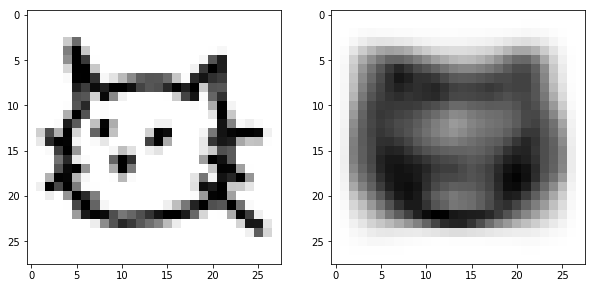

In [30]:
plt.rcParams['figure.figsize'] = (10, 5)

n = np.random.randint(len(data))

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data[n].reshape(28, 28),
                cmap='Greys');

axarr[1].imshow(autoencoder_2.predict(data[n].reshape(1, 28, 28, 1)).reshape(28, 28),
                cmap='Greys');

## display representations from the 2D latent space within a continuous manifold

In [31]:
latent_vector_2 = Input(shape=(2,))
x = Dense(64*7*7, activation='relu',
          weights=autoencoder_2.layers[10].get_weights())(latent_vector_2)
x = Reshape((-1, 7, 7, 64)[1:])(x)
x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',
           weights=autoencoder_2.layers[13].get_weights())(x)
x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',
           weights=autoencoder_2.layers[15].get_weights())(x)
decoded_2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', data_format='channels_last',
                   weights=autoencoder_2.layers[16].get_weights())(x)

decoder_2 = Model(latent_vector_2, decoded_2)

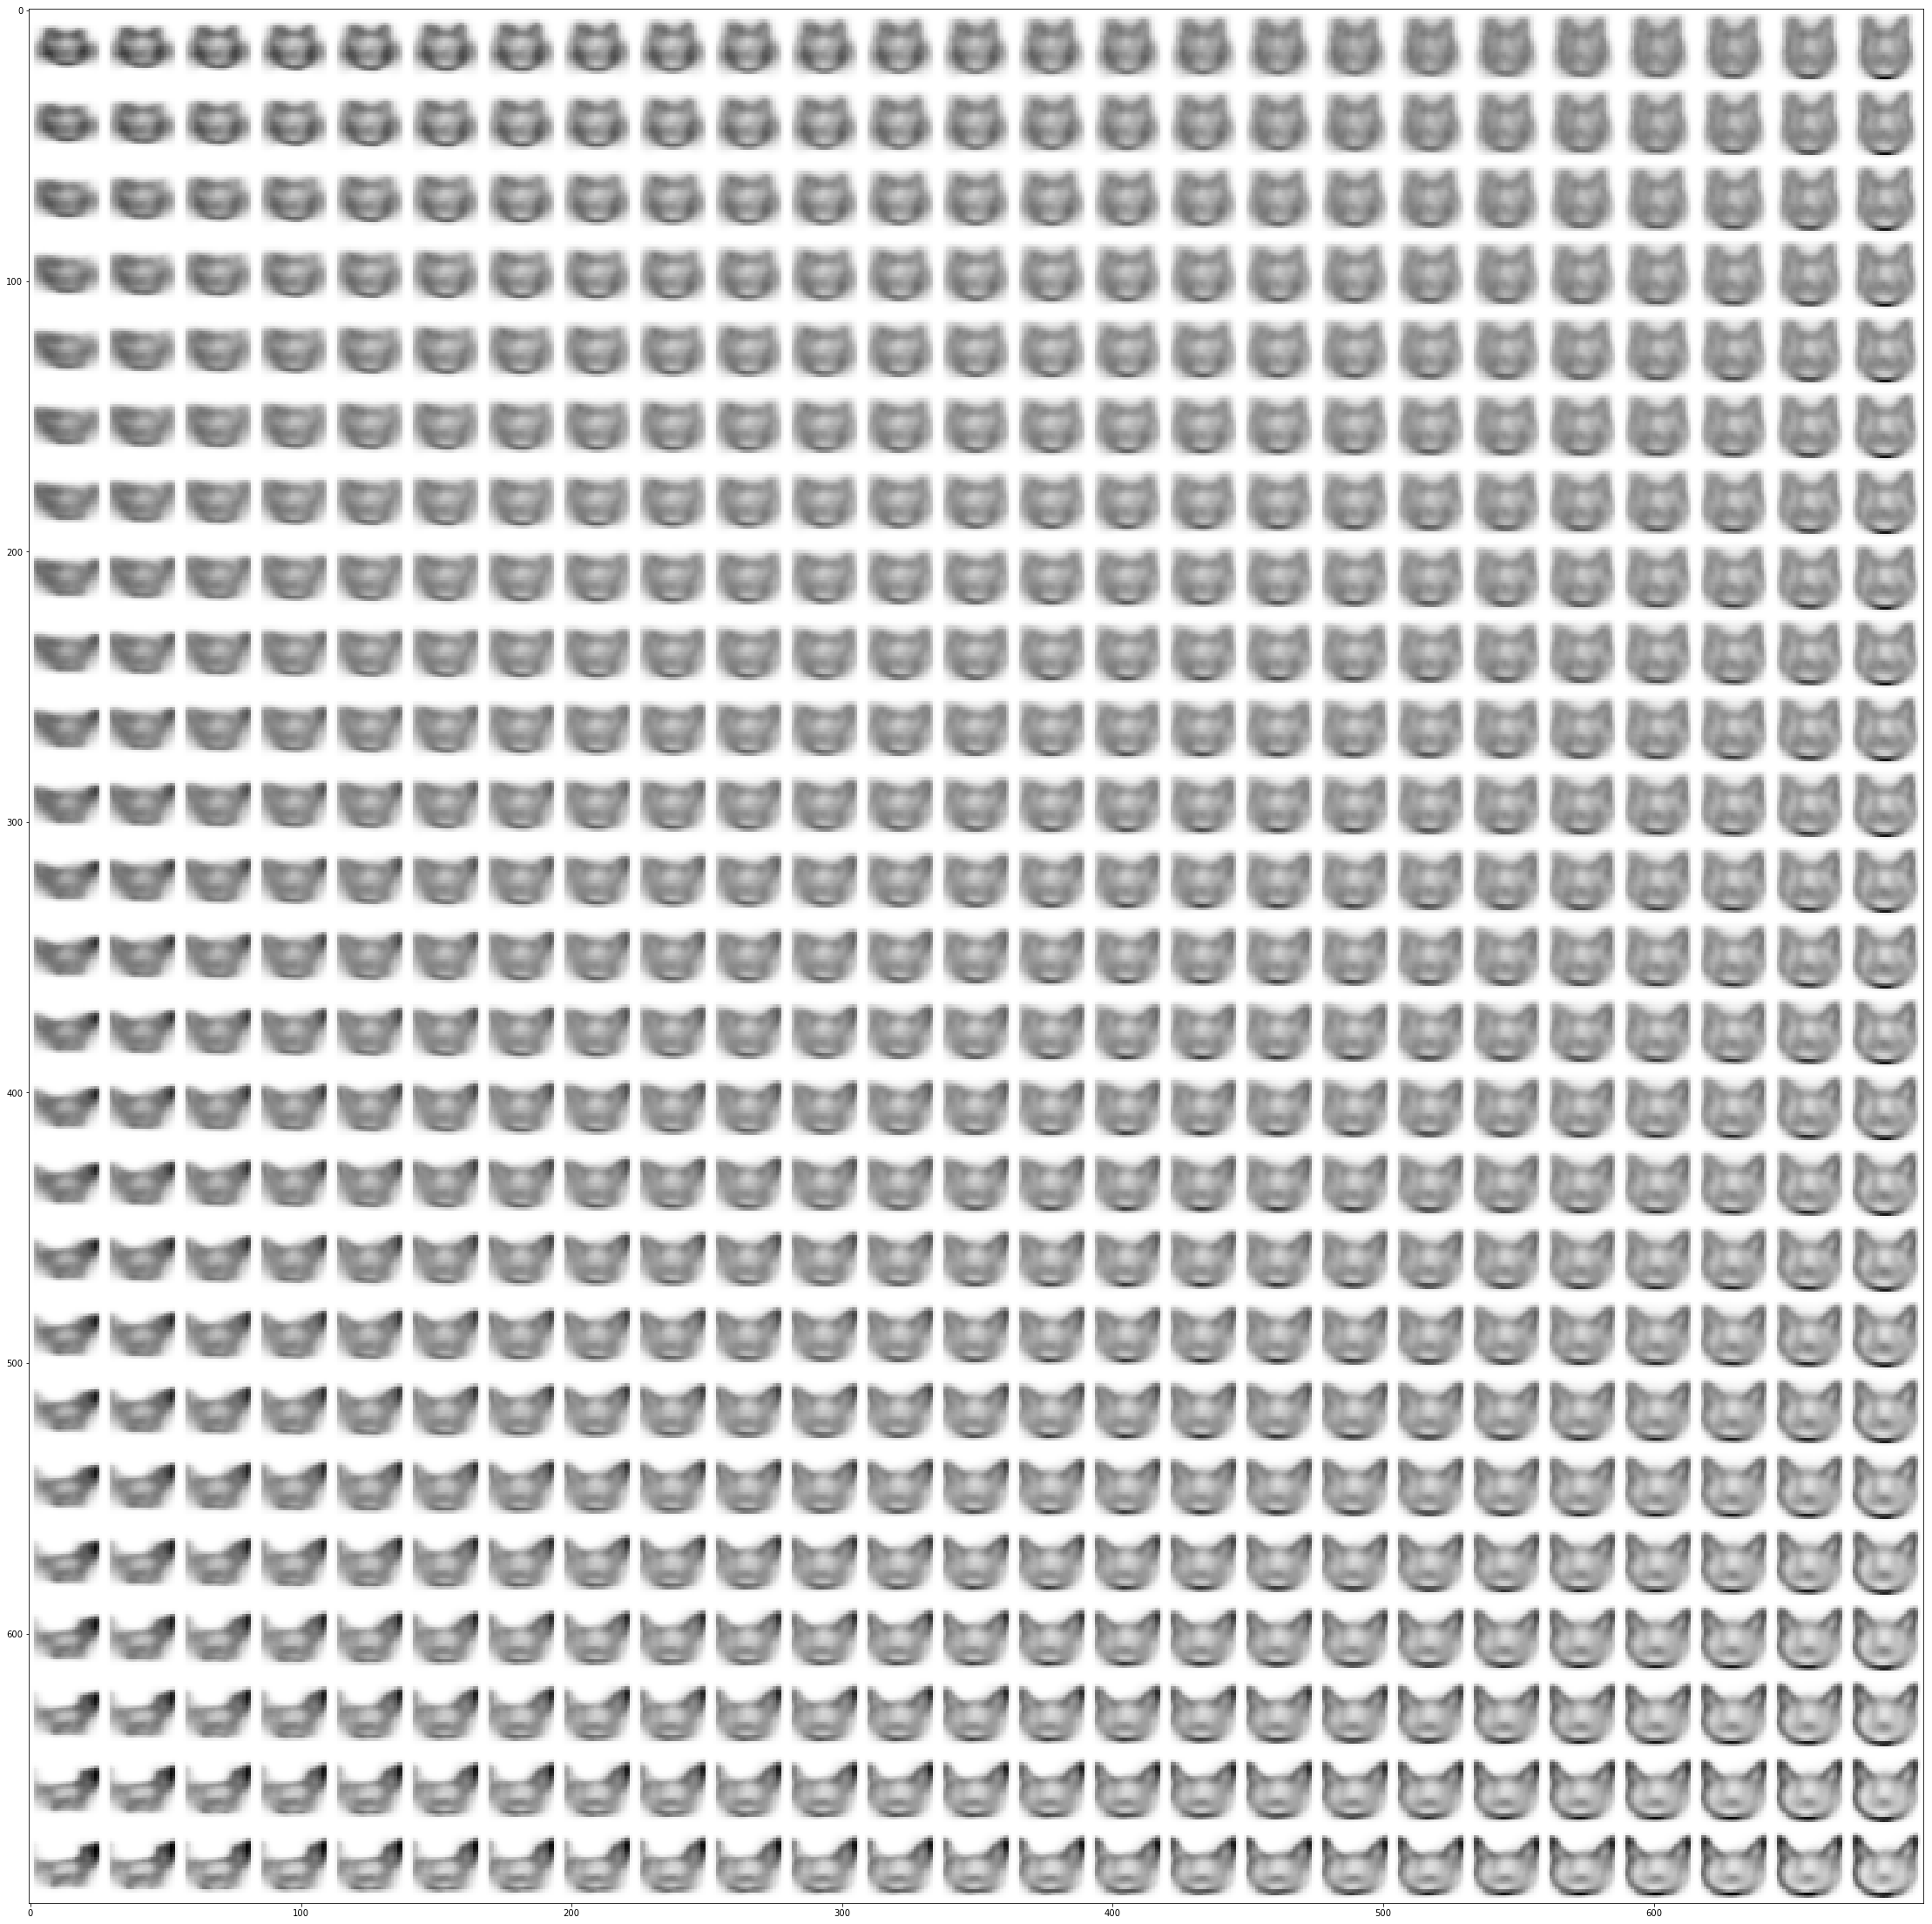

In [32]:
figure = np.zeros((700, 700))
grid_x = norm.ppf(np.linspace(0.05, 0.95, 25))
grid_y = norm.ppf(np.linspace(0.05, 0.95, 25))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        x_decoded = decoder_2.predict(np.array([[xi, yi]]))
        figure[i * 28: (i + 1) * 28, 
               j * 28: (j + 1) * 28] = x_decoded[0].reshape(28, 28)

plt.figure(figsize=(40, 40));
plt.imshow(figure, cmap='Greys');